<a href="https://colab.research.google.com/github/kas1998/series-de-tiempo/blob/main/serie_de_tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip uninstall statsmodels

Found existing installation: statsmodels 0.14.4
Uninstalling statsmodels-0.14.4:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/statsmodels-0.14.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/statsmodels/*
Proceed (Y/n)? y
  Successfully uninstalled statsmodels-0.14.4


In [ ]:
pip install statsmodels --upgraded


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --upgraded


In [ ]:
!pip install pmdarima # libreria con la función auto_arima()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 85.6 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow numpy pandas matplotlib seaborn statsmodels scikit-learn scipy pmdarima prophet


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy import stats
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from prophet import Prophet



%matplotlib inline
sns.set()

In [ ]:
import logging
import warnings

# Silenciar warnings de Prophet
warnings.filterwarnings("ignore")

# Configurar logging para minimizar mensajes
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

In [ ]:
url = '/content/datasets_56102_107707_monthly-beer-production-in-austr.csv'
data = pd.read_csv(url)
data.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


from matplotlib import pyplot as plt
_df_0['Monthly beer production'].plot(kind='hist', bins=20, title='Monthly beer production')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Month').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Monthly beer production'].plot(kind='line', figsize=(8, 4), title='Monthly beer production')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['Month'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='Monthly beer production', y='Month', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [ ]:
data.Month = pd.to_datetime(data.Month)
data.set_index('Month', inplace=True)
data.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [ ]:
data['Log_Production']=np.log(data['Monthly beer production'])

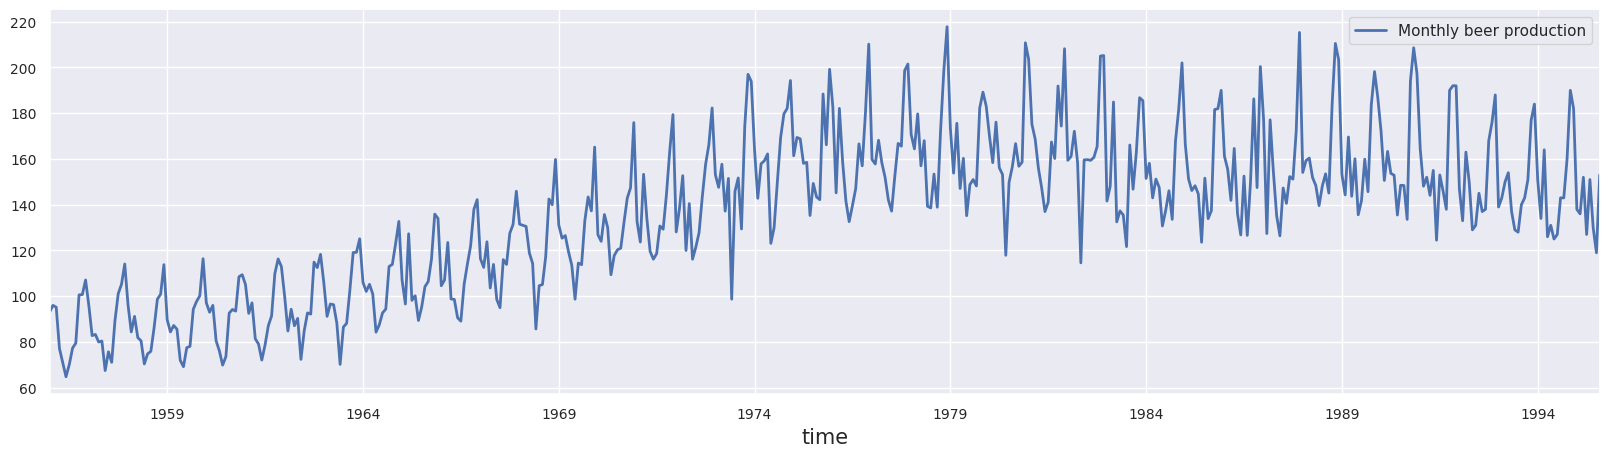

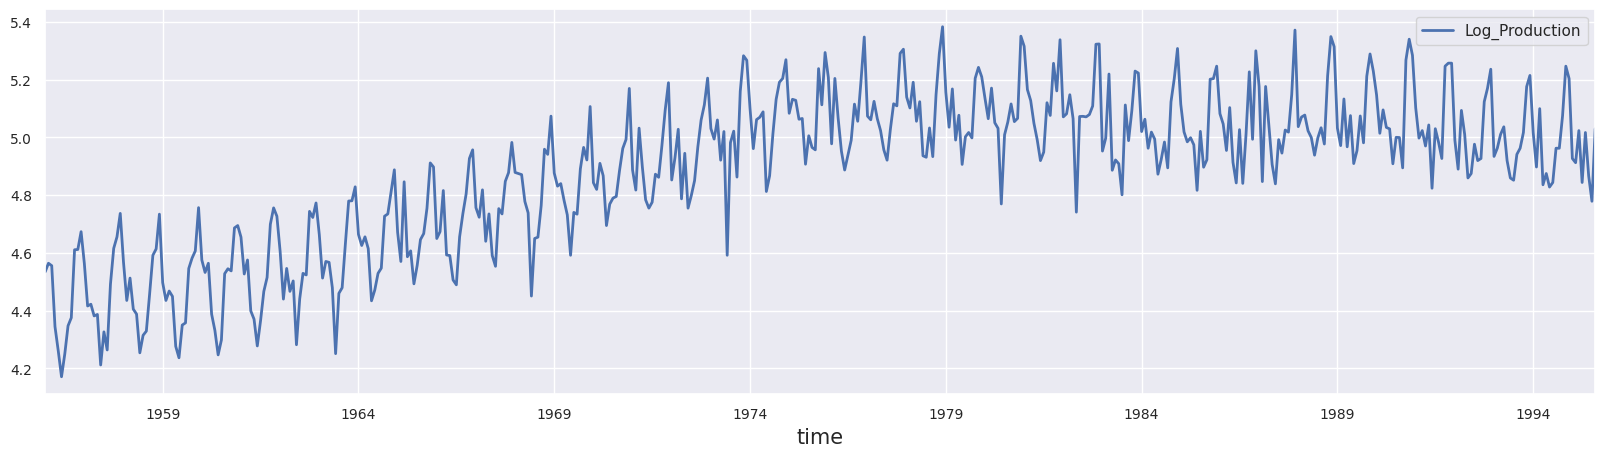

In [ ]:
#Evolución de producción de cerveza en Australia durante el periodo de análisis
data[['Monthly beer production']].plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);
data[['Log_Production']].plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

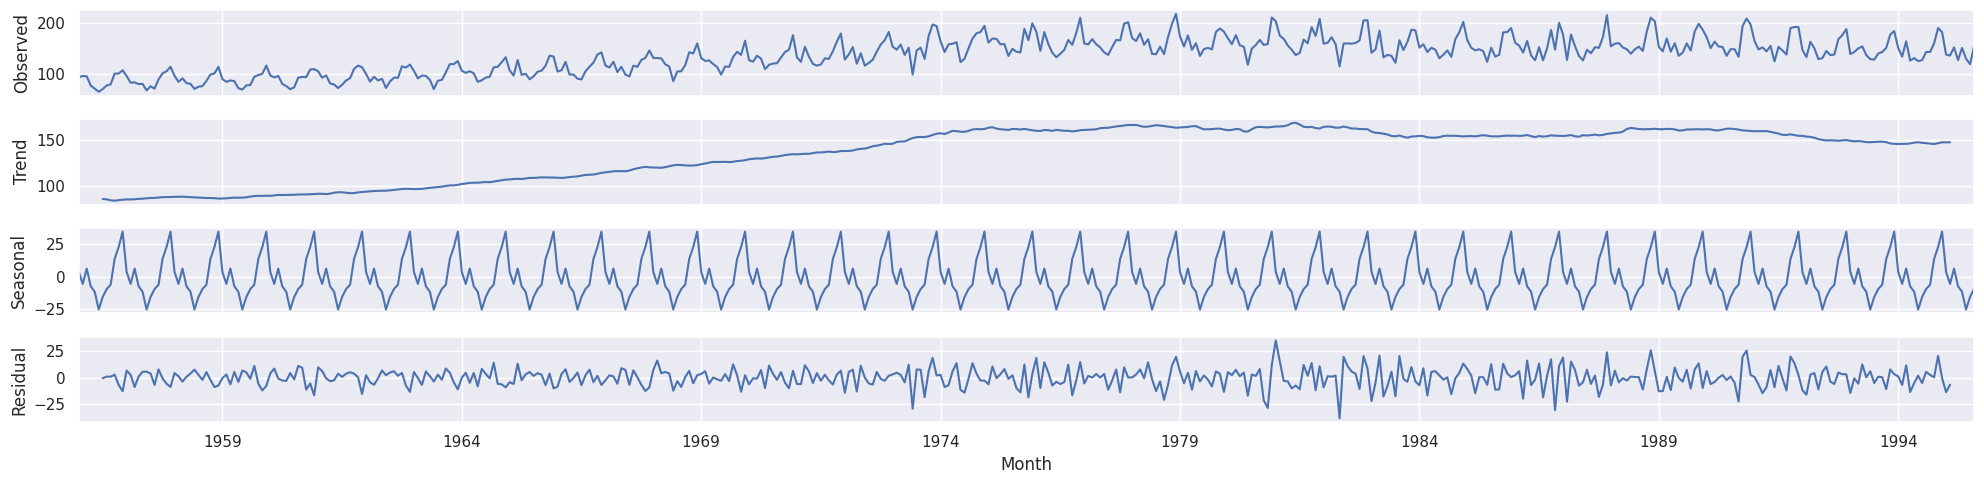

In [ ]:
res = seasonal_decompose(data['Monthly beer production'], model='additive', period=12)

def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(20, 5))

plotseasonal(res, axes)

plt.tight_layout()
plt.show()


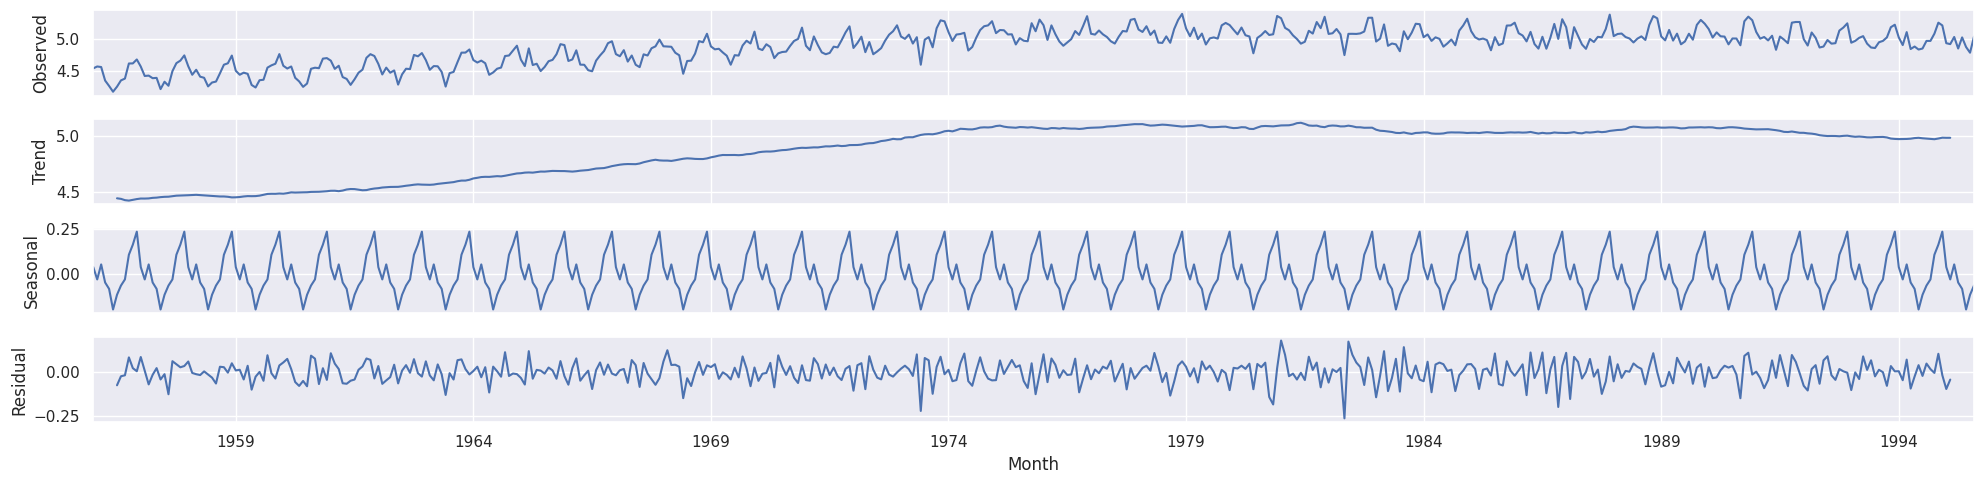

In [ ]:
res = seasonal_decompose(data['Log_Production'], model='additive',period=12)

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(20,5))

plotseasonal(res, axes)

plt.tight_layout()
plt.show()

## Modelo Arima


In [ ]:
X = data['Log_Production'].values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]

# Función ARIMA
def ARIMA_FUNCTION(p, q):
    predictions = []  # Reiniciar las predicciones en cada llamada
    history = [x for x in train]  # Inicializar el historial
    for t in range(len(test)):
        model_1 = ARIMA(history, order=(p, 1, q))
        model_fit_1 = model_1.fit()  # Sin 'disp=0'
        output = model_fit_1.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)  # Agregar el valor real al historial
    return mean_squared_error(test, predictions)**0.5  # Calcular el RMSE

In [ ]:
results = []
for i in range(3):
    for j in range(4):
        if (i > j or i == 0) and (i - j < 3):
            result = ARIMA_FUNCTION(i, j)  # Llamar la función ARIMA
            results.append([i, j, result])  # Almacenar el resultado
            print(f"Completado para (p={i}, q={j}): RMSE = {result}")

# Mostrar resultados finales
print("\nResultados finales:")
print(results)

Completado para (p=0, q=0): RMSE = 0.13978763350444914
Completado para (p=0, q=1): RMSE = 0.13625493700965113
Completado para (p=0, q=2): RMSE = 0.1190945100977509
Completado para (p=0, q=3): RMSE = 0.122611098079949
Completado para (p=1, q=0): RMSE = 0.13852361826548623
Completado para (p=2, q=0): RMSE = 0.13487309079522003
Completado para (p=2, q=1): RMSE = 0.13333009413774605

Resultados finales:
[[0, 0, 0.13978763350444914], [0, 1, 0.13625493700965113], [0, 2, 0.1190945100977509], [0, 3, 0.122611098079949], [1, 0, 0.13852361826548623], [2, 0, 0.13487309079522003], [2, 1, 0.13333009413774605]]


In [ ]:
model = ARIMA(train, order=(0,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  428
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 281.844
Date:                Tue, 21 Jan 2025   AIC                           -557.688
Time:                        18:53:38   BIC                           -545.518
Sample:                             0   HQIC                          -552.881
                                - 428                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4638      0.047     -9.884      0.000      -0.556      -0.372
ma.L2         -0.4294      0.052     -8.309      0.000      -0.531      -0.328
sigma2         0.0156      0.001     13.781      0.0

In [ ]:
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model_1 = ARIMA(history, order=(0,1,2))
    model_fit_1 = model_1.fit()
    output = model_fit_1.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=4.996508, expected=4.927254
predicted=5.008252, expected=5.247024
predicted=5.166710, expected=5.257495
predicted=5.112389, expected=5.257495
predicted=5.151599, expected=4.990433
predicted=5.002025, expected=4.890349
predicted=5.011440, expected=5.093750
predicted=5.104221, expected=5.010635
predicted=5.017938, expected=4.859812
predicted=4.972976, expected=4.875197
predicted=4.988738, expected=4.976734
predicted=5.024908, expected=4.919981
predicted=4.973031, expected=4.927254
predicted=4.993875, expected=5.123964
predicted=5.084818, expected=5.170484
predicted=5.074631, expected=5.236442
predicted=5.125369, expected=4.934474
predicted=4.950937, expected=4.962845
predicted=5.040542, expected=5.010635
predicted=5.019216, expected=5.036953
predicted=5.041821, expected=4.919981
predicted=4.968254, expected=4.859812
predicted=4.962485, expected=4.852030
predicted=4.949599, expected=4.941642
predicted=4.993429, expected=4.962845
predicted=4.980238, expected=5.017280
predicted=5.

In [ ]:
error_ARIMA = mean_squared_error(test, predictions)**0.5
print('Test RMSE: %.3f' % error_ARIMA)

Test RMSE: 0.119


In [ ]:
RollBack = pd.concat([
    pd.DataFrame({'TEST': test}),
    pd.DataFrame({'ARIMA': predictions})
], axis=1)

print(RollBack.head())


       TEST     ARIMA
0  4.927254  4.996508
1  5.247024  5.008252
2  5.257495  5.166710
3  5.257495  5.112389
4  4.990433  5.151599


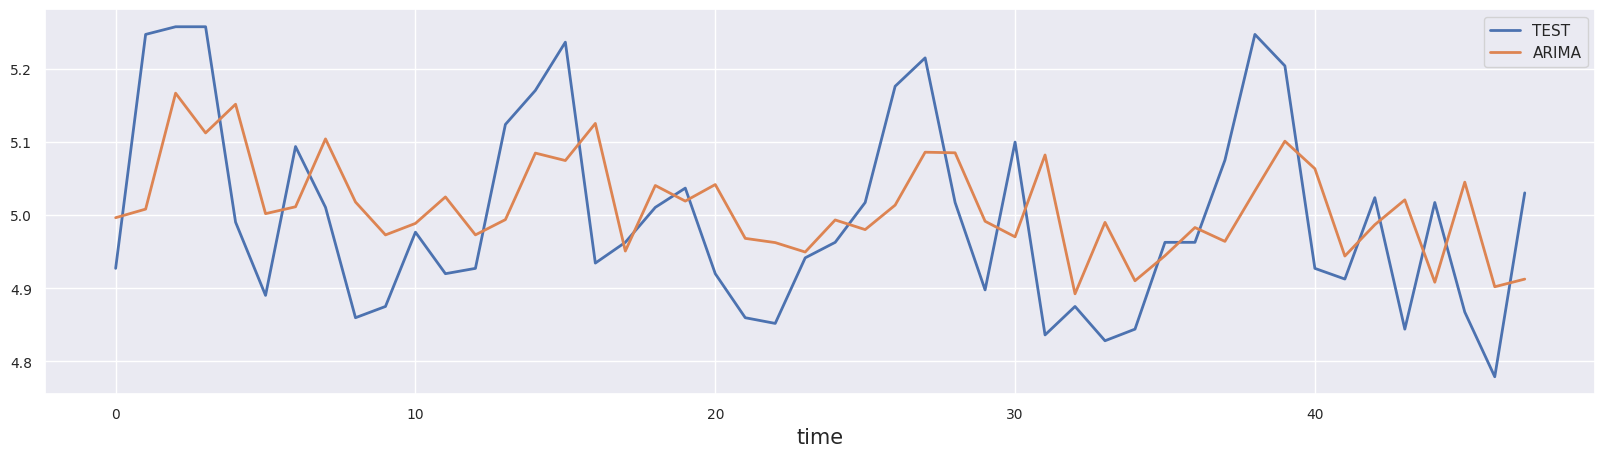

In [ ]:
RollBack.plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

## Prophet Forecast

In [ ]:
data_pf = pd.DataFrame({'ds': data.Log_Production.index[:], 'y': data.Log_Production})
data_pf.head()

,ds,y
Month,,
1956-01-01,1956-01-01,4.534748
1956-02-01,1956-02-01,4.564348
1956-03-01,1956-03-01,4.555980
1956-04-01,1956-04-01,4.345103
1956-05-01,1956-05-01,4.261270


In [ ]:
import logging
import warnings

# Silenciar warnings de Prophet
warnings.filterwarnings("ignore")

# Configurar logging para minimizar mensajes
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)


In [ ]:
X = data_pf.y
Y = data_pf.ds
size = int(len(X) * 0.9)
train_X, test_X = X[0:size], X[size:len(X)]
train_Y, test_Y = Y[0:size], Y[size:len(Y)]

Train = pd.concat([train_Y,train_X], axis=1)
Test = pd.concat([test_Y,test_X], axis=1)

In [ ]:
predictions = list()

predictions = list()

def rolling_forecast():
    history = Train.copy()

    for t in range(len(test_X)):
        m = Prophet()
        m.fit(history)
        future = m.make_future_dataframe(periods=1, freq='MS')
        forecast = m.predict(future)
        yhat = forecast['yhat'].iloc[-1]  # Predicción del próximo valor
        predictions.append(yhat)

        obs = Test[['ds', 'y']].iloc[t]
        print('predicted=%.6f, expected=%.6f' % (yhat, obs['y']))  # Solo imprimir predicted y expected

    # Calcular y mostrar el error RMSE
    error_PROPHET = mean_squared_error(test_X, predictions) ** 0.5
    print('Test RMSE: %.3f' % error_PROPHET)

rolling_forecast()


predicted=5.036087, expected=4.927254
predicted=5.036087, expected=5.247024
predicted=5.036087, expected=5.257495
predicted=5.036087, expected=5.257495
predicted=5.036087, expected=4.990433
predicted=5.036087, expected=4.890349
predicted=5.036087, expected=5.093750
predicted=5.036087, expected=5.010635
predicted=5.036087, expected=4.859812
predicted=5.036087, expected=4.875197
predicted=5.036087, expected=4.976734
predicted=5.036087, expected=4.919981
predicted=5.036087, expected=4.927254
predicted=5.036087, expected=5.123964
predicted=5.036087, expected=5.170484
predicted=5.036087, expected=5.236442
predicted=5.036087, expected=4.934474
predicted=5.036087, expected=4.962845
predicted=5.036087, expected=5.010635
predicted=5.036087, expected=5.036953
predicted=5.036087, expected=4.919981
predicted=5.036087, expected=4.859812
predicted=5.036087, expected=4.852030
predicted=5.036087, expected=4.941642
predicted=5.036087, expected=4.962845
predicted=5.036087, expected=5.017280
predicted=5.

In [ ]:
error_PROPHET = mean_squared_error(test_X, predictions) **0.5
print('Test RMSE: %.3f' % error_PROPHET)

Test RMSE: 0.138


Para el proceso del Rolling Forecast con Prophet separamos la base en train (90% de obs) para estimar el modelo y en test (10%) para calcular el error de la predicción. Dicho esto, escogemos el modelo con menor RMSE el cual es el que predice mejor, en este caso con un RMSE=0.078

In [ ]:
RollBack=pd.concat([RollBack,pd.DataFrame({'Prophet':predictions})],axis=1)
RollBack.head()

,TEST,ARIMA,Prophet
0,4.927254,4.996508,4.996508
1,5.247024,5.008252,5.008252
2,5.257495,5.166710,5.166710
3,5.257495,5.112389,5.112389
4,4.990433,5.151599,5.151599


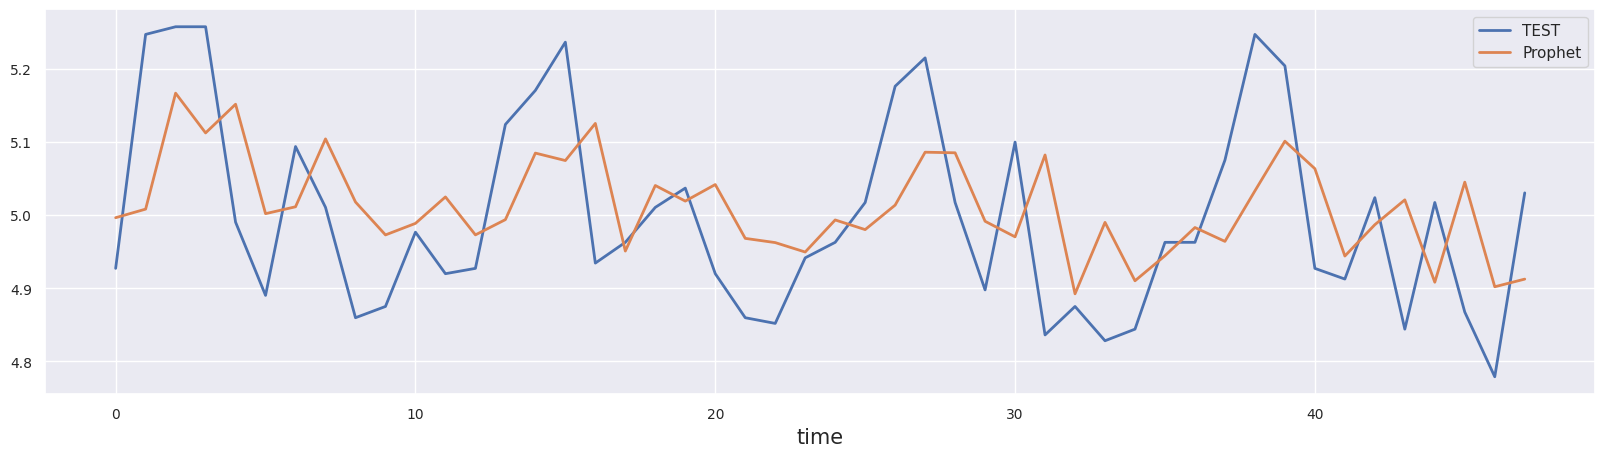

In [ ]:
RollBack[['TEST', 'Prophet']].plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

## **LSTM Forecast**

In [ ]:
data_LSTM = pd.DataFrame({'Log_Production': data.Log_Production})
data_LSTM.head()

,Log_Production
Month,
1956-01-01,4.534748
1956-02-01,4.564348
1956-03-01,4.555980
1956-04-01,4.345103
1956-05-01,4.261270


In [ ]:
Y = data_LSTM
size = int(len(Y) * 0.9)

train_Y, test_Y = Y[0:size], Y[size:len(Y)]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_Y)
scaled_train_data = scaler.transform(train_Y)
scaled_test_data = scaler.transform(test_Y)

In [ ]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 200)                 │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,801 (632.04 KB)

 Trainable params: 161,801 (632.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_model.fit(generator,epochs=20)

Epoch 1/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0423
Epoch 2/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0172
Epoch 3/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0116
Epoch 4/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0074
Epoch 5/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0072
Epoch 6/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0078
Epoch 7/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0084
Epoch 8/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0074
Epoch 9/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0062
Epoch 10/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0064
Epoch 11/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0075
Epoch 12/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0069
Epoch 13/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0062
Epoch 14/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0069
Epoch 15/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 7

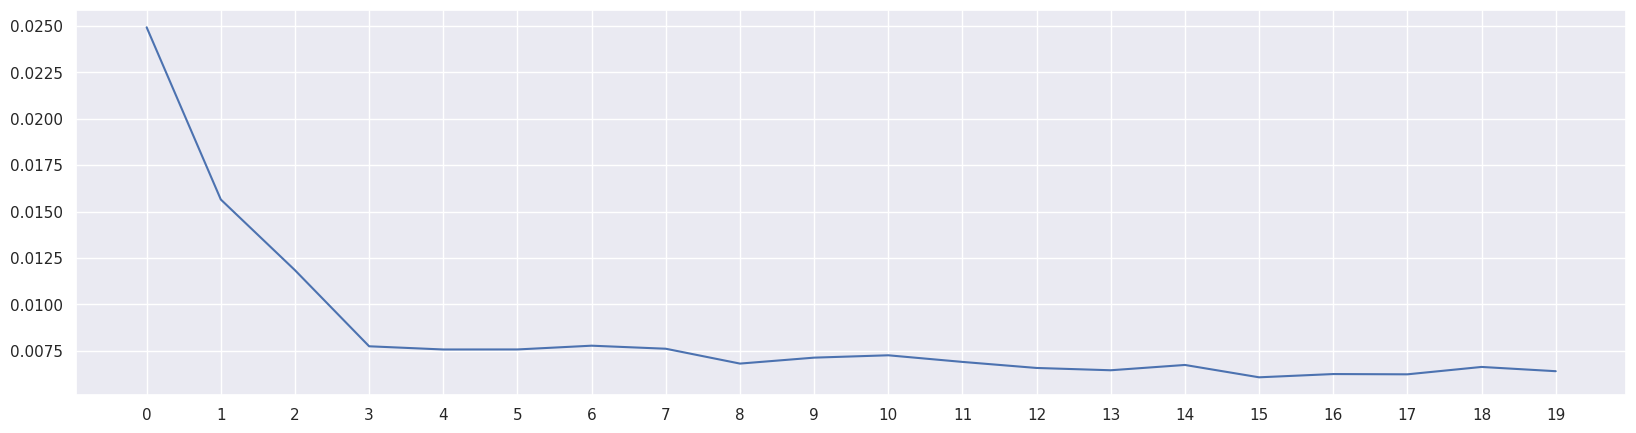

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(20,5))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [ ]:
error_LSTM = mean_squared_error(test, lstm_predictions) ** 0.5
print('Test RMSE: %.3f' % error_LSTM)

Test RMSE: 0.192


In [ ]:
RollBack = pd.concat([RollBack,pd.DataFrame({'LSTM':np.concatenate(lstm_predictions, axis=0)})],axis=1)
RollBack.head()

,TEST,ARIMA,Prophet,LSTM
0,4.927254,4.996508,4.996508,5.124857
1,5.247024,5.008252,5.008252,5.241622
2,5.257495,5.166710,5.166710,5.258110
3,5.257495,5.112389,5.112389,5.224577
4,4.990433,5.151599,5.151599,5.168543


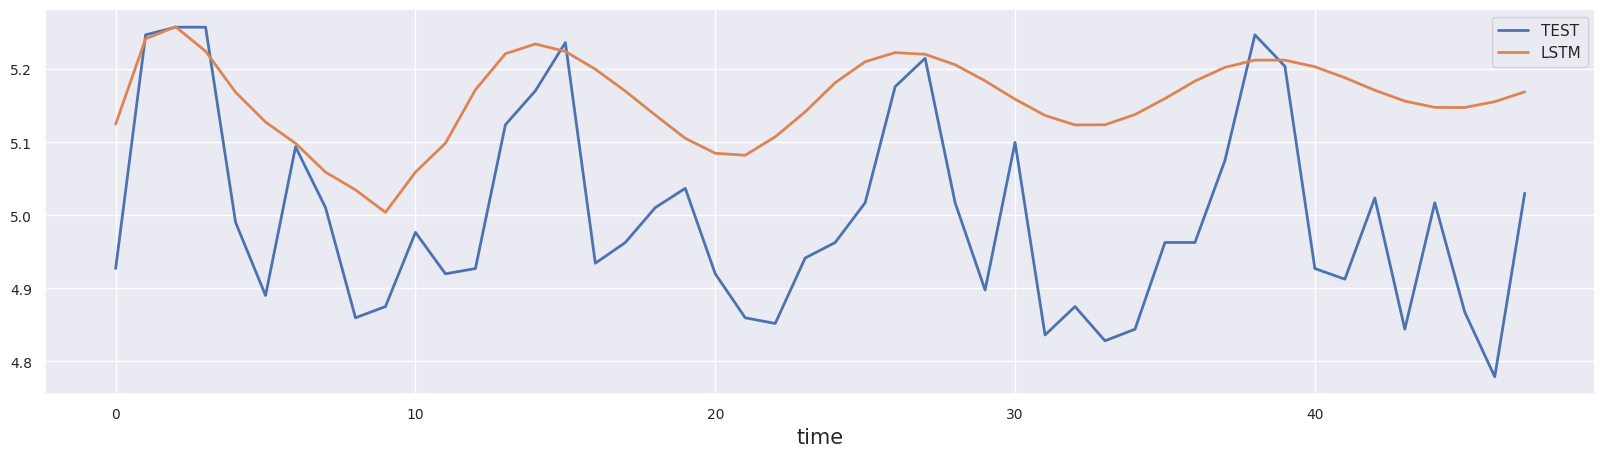

In [ ]:
RollBack[['TEST', 'LSTM']].plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

## **Conclusiones: **

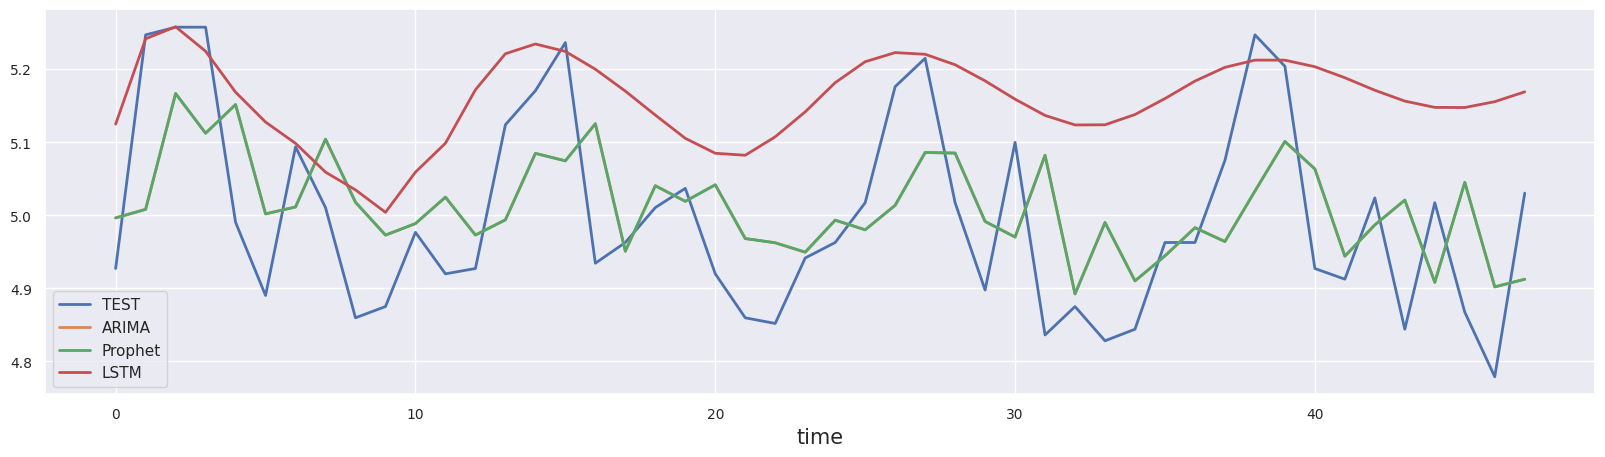

In [ ]:
RollBack.plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

In [ ]:
RollBack = pd.concat([RollBack,pd.DataFrame({'Time':data.Log_Production.index[size:]})],axis=1)
RollBack.head()

,TEST,ARIMA,Prophet,LSTM,Time
0,4.927254,4.996508,4.996508,5.124857,1991-09-01
1,5.247024,5.008252,5.008252,5.241622,1991-10-01
2,5.257495,5.166710,5.166710,5.258110,1991-11-01
3,5.257495,5.112389,5.112389,5.224577,1991-12-01
4,4.990433,5.151599,5.151599,5.168543,1992-01-01


In [ ]:
RollBack.set_index('Time', inplace=True)
RollBack.head()

,TEST,ARIMA,Prophet,LSTM
Time,,,,
1991-09-01,4.927254,4.996508,4.996508,5.124857
1991-10-01,5.247024,5.008252,5.008252,5.241622
1991-11-01,5.257495,5.166710,5.166710,5.258110
1991-12-01,5.257495,5.112389,5.112389,5.224577
1992-01-01,4.990433,5.151599,5.151599,5.168543


In [ ]:
Error = pd.DataFrame({"Models":["ARIMA", "Prophet", "LSTM"],
                      "RMSE Log" : [error_ARIMA, error_PROPHET, error_LSTM]})
Error

,Models,RMSE Log
0,ARIMA,0.119095
1,Prophet,0.137507
2,LSTM,0.192205
